$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Hidden Markov Model and LQR
This is an example of learning a HMM over some trajectories demonstrations and reproducing it using optimal control.
More infos : http://calinon.ch/papers/Calinon-JIST2015.pdf, http://calinon.ch/papers/Calinon-HFR2016.pdf


## Learning Hidden Markov Model (HMM)

In [2]:
from scipy.io import loadmat # loading data from matlab

letter = 'C' # choose a letter in the alphabet

datapath = os.path.dirname(pbd.__file__) + '/data/2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)

demos_x = [d['pos'][0][0].T for d in data['demos'][0]] # Position data
demos_dx = [d['vel'][0][0].T for d in data['demos'][0]] # Velocity data
demos_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(demos_x, demos_dx)] # Position-velocity

EM did not converge


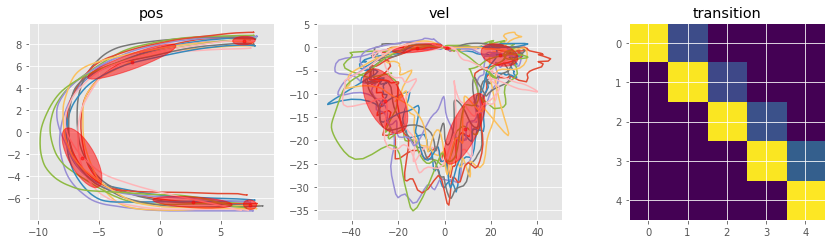

In [3]:
model = pbd.HMM(nb_states=5, nb_dim=4)

model.init_hmm_kbins(demos_xdx) # initializing model

# EM to train model
model.em(demos_xdx, reg=1e-3) 


# plotting
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,3.5)

# position plotting
ax[0].set_title('pos')
for p in demos_x:
    ax[0].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 

# velocity plotting
ax[1].set_title('vel')
for p in demos_dx:
    ax[1].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 


# plotting transition matrix
ax[2].set_title('transition')
ax[2].imshow(np.log(model.Trans+1e-10), interpolation='nearest', vmin=-5, cmap='viridis');
plt.tight_layout()

# Reproduction (LQR) 
Using Product of Gaussian formulation with augmented transfer matrices see : http://calinon.ch/papers/Calinon-HFR2016.pdf

### Get sequence of states 

/home/pignate/code/pbdlib/public/pbdlib/pbdlib/hmm.py:95: RuntimeWarning: divide by zero encountered in log
  logDELTA[:, 0] = np.log(self.init_priors + realmin * reg) + logB[:, 0]
/home/pignate/code/pbdlib/public/pbdlib/pbdlib/hmm.py:100: RuntimeWarning: divide by zero encountered in log
  PSI[i, t] = np.argmax(logDELTA[:, t - 1] + np.log(self.Trans[:, i] + realmin * reg))
/home/pignate/code/pbdlib/public/pbdlib/pbdlib/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  logDELTA[i, t] = np.max(logDELTA[:, t - 1] + np.log(self.Trans[:, i] + realmin * reg)) + logB[i, t]


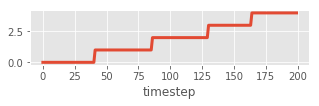

In [4]:
demo_idx = 0
sq = model.viterbi(demos_xdx[demo_idx])

plt.figure(figsize=(5, 1))
# plt.axis('off')
plt.plot(sq, lw=3);
plt.xlabel('timestep');

## Create and solve LQR 

In [5]:
A, b = pbd.utils.get_canonical(2, 2, 0.01)

In [6]:
lqr = pbd.LQR(A, b, horizon=demos_xdx[demo_idx].shape[0])
lqr.gmm_xi = model, sq
lqr.gmm_u = -4.

In [7]:
lqr.ricatti()

In [8]:
# create a two state GMM to define target distribution for via point
# state 0: when via-point does not apply, zero-centered and zero-precision
# state 1: when via-point apply with a precision only for position variables

model_vp = pbd.GMM(nb_dim=2, nb_states=2)
# specifiy the means
model_vp.mu = np.array([
        [0., 0., 0., 0.], # state 0, position and velocity
        [-2.5, 2., 0., 0.] # state 1, position and velocity
    ])

# specify the precision matrices
std_vp_pos = 0.1
model_vp.lmbda = np.zeros((2, 4, 4))
model_vp.lmbda[1, :2, :2] = 0.1 ** -2 * np.eye(2)

In [9]:
start_vp = 100  # starting time of via point cost
dur_vp = 10  # duration of the via point cost

lqr_vp = pbd.LQR(A, b, horizon=lqr.horizon)

# create sequence of state [0, 0, 0, ... , 1, 1, 1, ... 0, 0, ....]
seq_vp = [0] * (lqr_vp.horizon-start_vp) + [1] * dur_vp + [0] * (lqr_vp.horizon - start_vp - dur_vp)
# feed model and sequence
lqr_vp.gmm_xi = model_vp, seq_vp
lqr_vp.gmm_u = -4.

In [10]:
lqr_vp.ricatti()

In [16]:
def get_product_policy(x, t):
    # get Gaussian policies of LQR
    u, lmbda_u = -lqr.K[t].dot(x) + lqr.cs[t], lqr.Q[t]
    u_vp, lmbda_u_vp = -lqr_vp.K[t].dot(x) + lqr_vp.cs[t], lqr_vp.Q[t]
    
    # compute product of Gaussian policies
    lmbda_u_vp = lmbda_u + lmbda_u_vp
    sigma_u_vp = np.linalg.inv(lmbda_u_vp)
    u_p = sigma_u_vp.dot(lmbda_u.dot(u) + lmbda_u_vp.dot(u_vp))
    
    return u_p, sigma_u_vp, lmbda_u_vp

In [25]:
def integrate_policy(xi0, stochastic=False): 
    xis = [np.copy(xi0)]

    for i in range(0, lqr.horizon-1):
        u, sigma_u, lmbda_u = get_product_policy(xis[-1], i)  
        
        if stochastic:
            u = np.random.multivariate_normal(u, sigma_u)
            print u
        
        xis += [A.dot(xis[-1]) + b.dot(u)]
    
    return np.array(xis)

In [26]:
xi = integrate_policy(demos_xdx[demo_idx][0], stochastic=True)

[-58.01 -35.27]
[-58.   -35.26]
[-49.76 -28.66]
[-49.76 -28.66]
[-42.5  -23.35]
[-42.5  -23.34]
[-36.17 -19.08]
[-36.18 -19.08]
[-30.72 -15.67]
[-30.71 -15.66]
[-26.1  -12.94]
[-26.1  -12.94]
[-22.27 -10.78]
[-22.27 -10.77]
[-19.17  -9.07]
[-19.18  -9.05]
[-16.77  -7.72]
[-16.76  -7.7 ]
[-15.03  -6.67]
[-15.04  -6.68]
[-13.93  -5.86]
[-13.94  -5.85]
[-13.44  -5.24]
[-13.43  -5.23]
[-13.54  -4.79]
[-13.53  -4.79]
[-14.22  -4.46]
[-14.22  -4.45]
[-15.48  -4.25]
[-15.47  -4.26]
[-17.32  -4.12]
[-17.32  -4.12]
[-19.77  -4.08]
[-19.78  -4.08]
[-22.82  -4.1 ]
[-22.81  -4.1 ]
[-26.52  -4.19]
[-26.52  -4.2 ]
[-30.87  -4.32]
[-30.88  -4.3 ]
[-35.91  -4.51]
[-35.91  -4.52]
[-41.65  -4.75]
[-41.64  -4.75]
[-48.08  -5.03]
[-48.07  -5.04]
[-55.17  -5.36]
[-55.17  -5.34]
[-62.86  -5.74]
[-62.87  -5.74]
[-71.03  -6.16]
[-71.02  -6.17]
[-79.52  -6.63]
[-79.51  -6.63]
[-88.11  -7.14]
[-88.11  -7.14]
[-96.55  -7.69]
[-96.55  -7.68]
[-104.55   -8.29]
[-104.53   -8.3 ]
[-111.8    -8.92]
[-111.8    -8.91]


## Plotting reproduced trajectory (position and velocity)

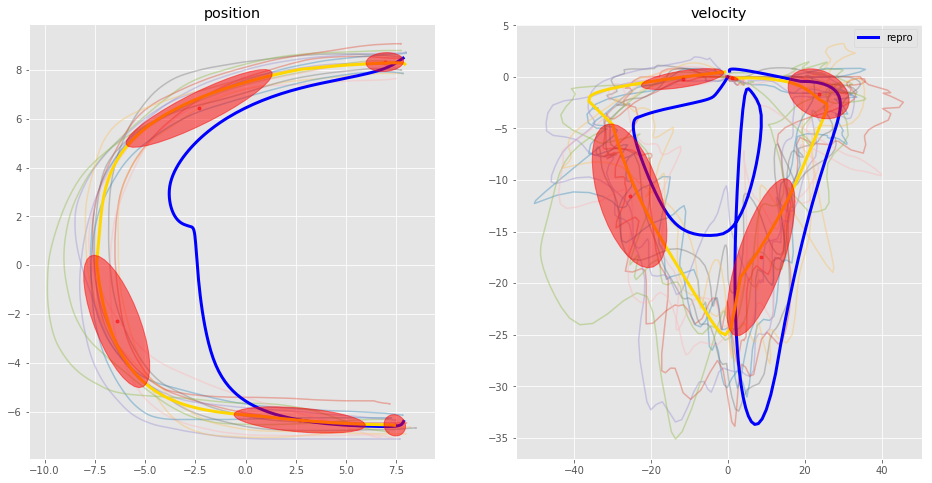

In [22]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16,8)


# position plotting 
ax[0].set_title('position')
for p in demos_x:
    ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1]); 
    
ax[0].plot(xi[:, 0], xi[:, 1], 'b', lw=3)
ax[0].plot(lqr.ds[:, 0], lqr.ds[:, 1], 'gold', lw=3)


# velocity plotting
ax[1].set_title('velocity')
for p in demos_dx:
    ax[1].plot(p[:, 0], p[:, 1], alpha=0.4)
    
ax[1].plot(xi[:, 2], xi[:, 3], 'b', lw=3, label='repro')
ax[1].plot(lqr.ds[:, 2], lqr.ds[:, 3], 'gold', lw=3)

plt.legend()
pbd.plot_gmm(model.mu, model.sigma, ax=ax[1], dim=[2, 3]); 
